### Анализ погибших на титанике

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, stats
import statsmodels.api as sm

from math import *

In [4]:
all_people = pd.read_csv("tested.csv")

##### Рассмотрим взаимосвязь возраста и класса каюты

In [5]:
all_people

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
all_people['Pclass'].astype(str)

all_people.loc[(all_people.Pclass == 1), 'Pclass'] = "First Class"
all_people.loc[(all_people.Pclass == 2), 'Pclass'] = "Second Class"
all_people.loc[(all_people.Pclass == 3), 'Pclass'] = "Third Class"

sert = all_people.Pclass.unique()
[all_people.loc[all_people.Pclass == i, 'Age'].shape[0] for i in sert]

[218, 93, 107]

Text(0.5, 1.0, 'Распределения в каждом классе')

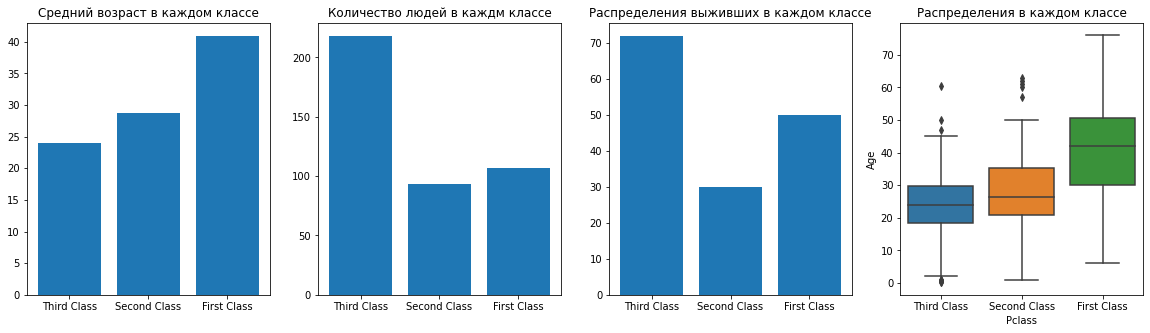

In [7]:
figure, axes = plt.subplots(1, 4, figsize=(20,5))

axes[0].bar(sert, [all_people.loc[all_people.Pclass == i, 'Age'].mean() for i in sert])
axes[0].set_title("Средний возраст в каждом классе")

axes[1].bar(sert, [all_people.loc[all_people.Pclass == i, 'Age'].shape[0] for i in sert])
axes[1].set_title("Количество людей в каждм классе")

axes[2].bar(sert, [all_people.query('Pclass == @i & Survived == 1').shape[0] for i in sert])
axes[2].set_title("Распределения выживших в каждом классе")

axes[3] = sns.boxplot(x='Pclass', y='Age', data=all_people)
axes[3].set_title("Распределения в каждом классе")


### На основе этих данных проверим гипотизу
##### Превилигированность класса на корабле влияла на выживаемость при караблекрушении

---
###### Сформируем 50 репрезентативные по 30 человек выборки над которыми, проведём t_test  
---

In [8]:
sert = all_people['Pclass'].unique()
all_people.loc[all_people['Pclass'] == sert[0], 'Pclass'].count()

218

In [9]:
def create_selection(table=None, column=None, size_sel=None, count_sel=None):
    procentag = np.array([])
    sert = table[column].unique()
    
    for i in sert:
        size_column = table.loc[table[column] == i, column].count()
        procentag = np.append(procentag, size_column)
        
    i = np.indices(procentag.shape)
    procentag[i] = procentag[i] / procentag.sum()
    
    all_select = []
    while count_sel != 0:    
        new_select = {}
        size_copy = size_sel
        for i in range(len(sert)):
            vibor =  table.loc[table[column] == sert[i]].sample(int(size_sel * procentag[i]), replace=False)
            new_select[sert[i]] = vibor
            
        all_select.append(new_select)
        count_sel -= 1
        
    return all_select
    

In [10]:
def create_count(arr_select, column):
    all_means_selects = {}
    
    for one_sel in arr_select:
        for name_sel in one_sel:
            data = one_sel[name_sel]
            prob = data.loc[data[column] == 1].count() / data[column].count()
            
            if all_means_selects.get(name_sel) is None:
                all_means_selects[name_sel] = np.array([prob])    
                                                       
            all_means_selects[name_sel] = np.append(all_means_selects[name_sel], prob)
            
    return all_means_selects

In [11]:
def t_test(date_group, column_one, column_two):
    mean_one = date_group[column_one].mean()
    mean_two = date_group[column_two].mean()
    
    std_one = date_group[column_one].std()
    std_two = date_group[column_two].std()
    
    count_one = date_group[column_one].shape[0]
    count_two = date_group[column_two].shape[0]
        
    return abs(mean_two - mean_one)/(sqrt(((std_one ** 2)/count_one) + ((std_two ** 2)/ count_two)))
    

In [ ]:
all_select = create_selection(all_people, 'Pclass', 30, 50)
date = create_count(all_select, 'Survived')

print(t_test(date, 'Third Class', 'First Class'))
print(ttest_ind(date['Third Class'], date['First Class']))

12.421331127568733
Ttest_indResult(statistic=-12.411178832347764, pvalue=2.1305225883795355e-33)


In [27]:
temp = all_people.groupby("Sex")['Age'].min().to_frame().reset_index()

In [28]:
temp

,Sex,Age
0,female,0.17
1,male,0.33
